# Adventures with Autodiff

------

#### Prepared for the CBC Workshop May 2024
#### John Stachurski

------

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

## What is automatic differentiation

Autodiff is a technique for calculating derivatives on a computer.

### Autodiff is not finite differences

The derivative of the exponential function $f(x) = \exp(2x)$ function is

$$
    (\exp(2 x))' = 2 \exp(2x)
$$

so the derivative at 0 is 2.


A computer that doesn't know how to take derivatives might approximate this with finite approximation

$$
    f_h(x) := \frac{f(x+h) - f(x)}{h}
    \quad \text{for some small } h > 0.
$$

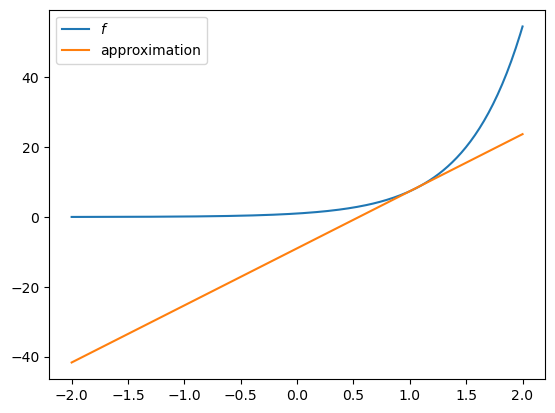

In [2]:
def f(x):
    return np.exp(2 * x)

def fh(x, h=0.1):
    return (f(x + h) - f(x))/h

x_grid = np.linspace(-2, 2, 200)
fig, ax = plt.subplots()
ax.plot(x_grid, f(x_grid), label="$f$")
ax.plot(x_grid, f(1.0) + fh(1.0) * (x_grid - 1.0), label="approximation")
ax.legend()
plt.show()

This kind of numerical derivative is often inaccurate and unstable.

One reason is that in the calculation of

$$
    \frac{f(x+h) - f(x)}{h} 
$$

we often have very small numbers in the numerator and denominator, which causes rounding errors.

The situation is exponentially worse in high dimensions, working with higher order derivatives

### Autodiff is not symbolic algebra

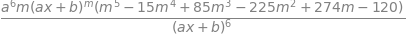

In [3]:
from sympy import symbols, diff, init_printing
init_printing(use_unicode=True)

m, a, b, x = symbols('m a b x')
expr = (a*x + b)**m
expr.diff((x, 6))  # 6-th order derivative

Symbolic calculus tries to use rules for differentiation to produce a single
closed-form expression representing a derivative.

This is useful at times but has disadvantages when considering high performance
computing.

One disadvantage is that it cannot differentiate through control flow, only through mathematical expressions.

Also, using symbolic calculus might involve many redundant calculations.

For example, consider

$$
    (f g h)'
    = (f' g + g' f) h + (f g) h'
$$

If we evaluate at $x$, then we evalute $f(x)$ and $g(x)$ twice each.

Also, computing $f'(x)$ and $f(x)$ might involve similar terms (e.g., $(\exp(2x)' = 2 \exp(2x)$) but this is not exploited in symbolic algebra.

### Autodiff 

Autodiff attempts to evaluate expressions numerically (using the rules of
calculus) at each stage, rather than manipulating large symbolic expressions.

Autodiff produces functions that evaluates derivatives at numerical values
passed in by the calling code, rather than producing a single symbolic
expression representing the entire derivative.

Derivatives are deconstructed into component parts via the chain rule.

The chain rule is applied until the point where the terms reduce to primitive functions that the program knows how to differentiate exactly (addition, subtraction, exponentiation, sine and cosine, etc.)

## Some experiments

Let's start with some real-valued functions on $\mathbb R$.

### A differentiable function

In [4]:
def f(x):
    return jnp.sin(x) - 2 * jnp.cos(3 * x) * jnp.exp(- x**2)

x_grid = jnp.linspace(-5, 5, 100)

In [5]:
f_prime = jax.grad(f)
f_prime_vec = jax.vmap(f_prime)

In [6]:
f_vals = f(x_grid)
f_prime_vals = f_prime_vec(x_grid)

In [7]:
f_vals = f(x_grid)
f_prime_vals = f_prime_vec(x_grid)

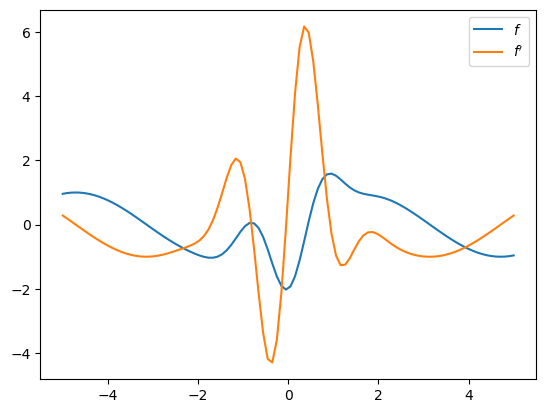

In [8]:
fig, ax = plt.subplots()
ax.plot(x_grid, f_vals, label="$f$")
ax.plot(x_grid, f_prime_vals, label="$f'$")
ax.legend()
plt.show()

### Absolute value function

In [9]:
def f(x):
    return jnp.abs(x)

In [10]:
f_prime = jax.grad(f)
f_prime_vec = jax.vmap(f_prime)

In [11]:
f_vals = f(x_grid)
f_prime_vals = f_prime_vec(x_grid)

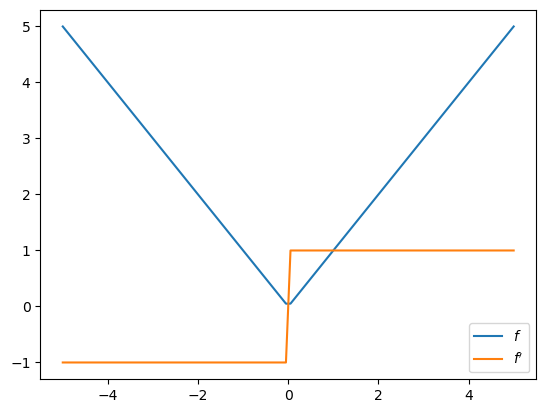

In [12]:
fig, ax = plt.subplots()
ax.plot(x_grid, f_vals, label="$f$")
ax.plot(x_grid, f_prime_vals, label="$f'$")
ax.legend()
plt.show()

### Differentiating through control flow

In [13]:
def f(x):
    if x < 0:
        for i in range(3):
            x *= x
    else:
        x = sum((x**i + i) for i in range(5))
    return x

In [14]:
def f(x):
    def f1(x):
        for i in range(2):
            x *= 0.2 * x
        return x
    def f2(x):
        x = sum((x**i + i) for i in range(3))
        return x
    y = jax.lax.cond(x < 0, f1, f2, x)
    return y

In [15]:
f_vec = jax.vmap(f)
f_prime = jax.grad(f)
f_prime_vec = jax.vmap(f_prime)

In [16]:
x_grid = jnp.linspace(-5, 5, 100)
f_vals = f_vec(x_grid)
f_prime_vals = f_prime_vec(x_grid)

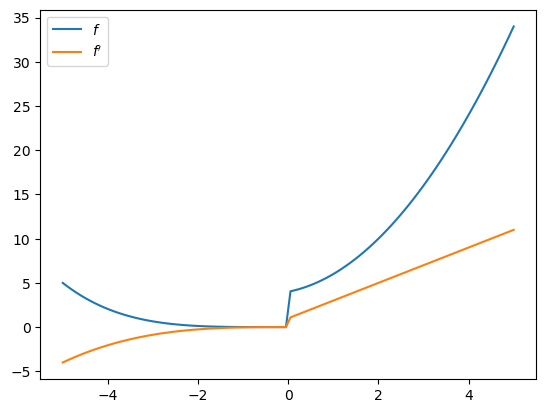

In [17]:
fig, ax = plt.subplots()
ax.plot(x_grid, f_vals, label="$f$")
ax.plot(x_grid, f_prime_vals, label="$f'$")
ax.legend()
plt.show()

### Differentiating through a linear interpolation

In [18]:
def f(x, xp):
    yp = jnp.cos(2 * xp)
    return jnp.interp(x, xp, yp)

xp = jnp.linspace(-5, 5, 25)

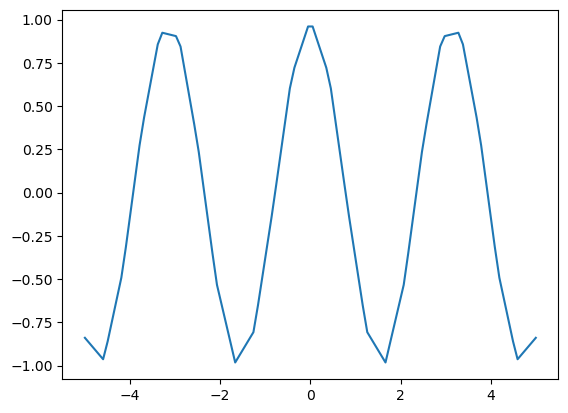

In [19]:
fig, ax = plt.subplots()
ax.plot(x_grid, f(x_grid, xp))
plt.show()

In [20]:
f_prime = jax.grad(f)
f_prime_vec = jax.vmap(f_prime, (0, None))

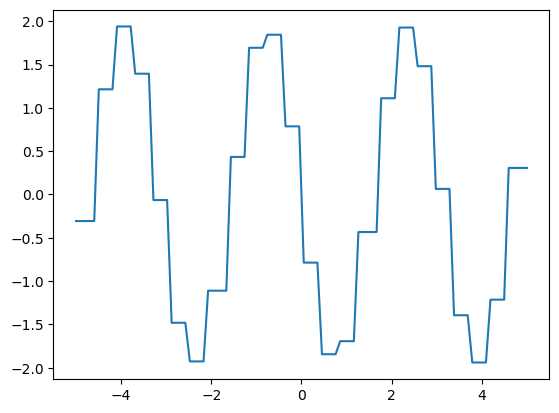

In [21]:
fig, ax = plt.subplots()
ax.plot(x_grid, f_prime_vec(x_grid, xp))
plt.show()

## Gradient Descent

Let's try implementing a simple version of gradient descent.

As a (very contrived) application, we'll use gradient descent to solve for the OLS parameter estimates in simple linear regression.

### Simulated data

Let's generate some simulated data:

In [22]:
n = 100
key = jax.random.PRNGKey(1234)
x = jax.random.uniform(key, (n,))

α, β = 0.5, 1.0  # Set the true intercept and slope.
key, subkey = jax.random.split(key)
y = α * x + β + 0.1 * jax.random.normal(subkey, (n,))

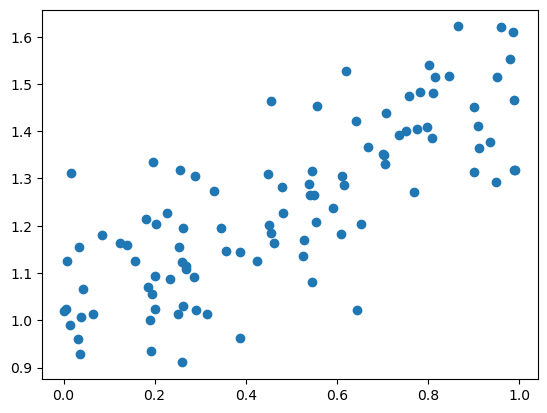

In [23]:
fig, ax = plt.subplots()
ax.scatter(x, y)
plt.show()

In [24]:
mx = x.mean()
my = y.mean()
α_hat = jnp.sum((x - mx) * (y - my)) / jnp.sum((x - mx)**2)
β_hat = my - α_hat * mx

In [25]:
α_hat, β_hat

(Array(0.45994443, dtype=float32), Array(1.0219054, dtype=float32))

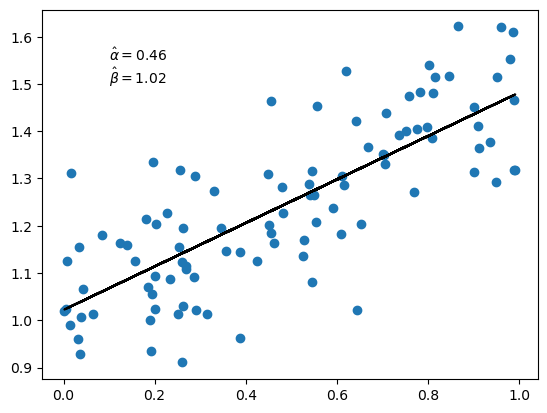

In [26]:
fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x, α_hat * x + β_hat, 'k-')
ax.text(0.1, 1.55, rf'$\hat \alpha = {α_hat:.3}$')
ax.text(0.1, 1.50, rf'$\hat \beta = {β_hat:.3}$')
plt.show()

### A function for gradient descent

In [27]:
def grad_descent(f,       # Function to be minimized
                 args,    # Extra arguments to the function
                 p0,      # Initial condition
                 λ=0.1,   # Initial learning rate
                 tol=1e-5, 
                 max_iter=1_000):
    
    f_grad = jax.grad(f)
    p = jnp.array(p0)
    df = f_grad(p, args)
    ϵ = tol + 1
    i = 0
    while ϵ > tol and i < max_iter:
        new_p = p - λ * df
        new_df = f_grad(new_p, args)
        Δp = new_p - p
        Δdf = new_df - df
        λ = jnp.abs(Δp @ Δdf) / (Δdf @ Δdf)
        ϵ = jnp.max(jnp.abs(Δp))
        p, df = new_p, new_df
        i += 1
        
    return p
    

### Minimizing squared loss by gradient descent

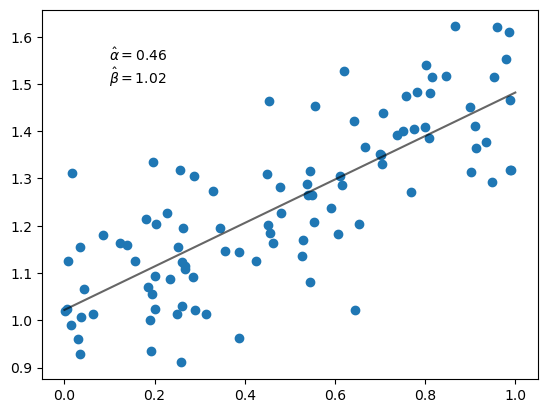

In [28]:
def loss(params, data):
    a, b = params
    x, y = data
    return jnp.sum((y - a * x - b)**2)

p0 = (1.0, 1.0)
data = x, y
α_hat, β_hat = grad_descent(loss, data, p0)

fig, ax = plt.subplots()
x_grid = jnp.linspace(0, 1, 100)
ax.scatter(x, y)
ax.plot(x_grid, α_hat * x_grid + β_hat, 'k-', alpha=0.6)
ax.text(0.1, 1.55, rf'$\hat \alpha = {α_hat:.3}$')
ax.text(0.1, 1.50, rf'$\hat \beta = {β_hat:.3}$')
plt.show()

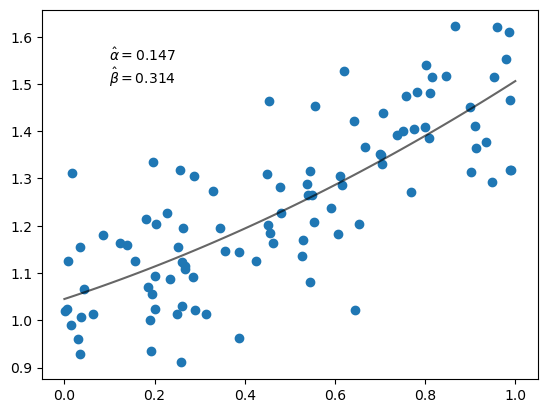

In [29]:
def loss(params, data):
    a, b, c = params
    x, y = data
    return jnp.sum((y - a * x**2 - b * x - c)**2)

p0 = jnp.ones(3)
α_hat, β_hat, γ_hat = grad_descent(loss, data, p0)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x_grid, α_hat * x_grid**2 + β_hat * x_grid + γ_hat, 'k-', alpha=0.6)
ax.text(0.1, 1.55, rf'$\hat \alpha = {α_hat:.3}$')
ax.text(0.1, 1.50, rf'$\hat \beta = {β_hat:.3}$')
plt.show()

## Exercise

Write a function called `poly` that with signature `poly(x, params)` that
computes the value of a polynomial at $x \in \mathbb R$.

The array `params` is the vector of polynomial coefficients.

For example, if `params = p0, p1, p2`, then the function returns

$$
    p_0 + p_1 x + p_2 x^2
$$

Once you have this function working, use it for polynomial regression.

The (empirical) loss becomes

$$
    \ell(p, x, y) 
    = \sum_{i=1}^n (y_i = f(x_i; p))^2
$$

where $f(x_i, p)$ is the polynomial with coefficient vector $p$ evaluated at point $x_i$.

Set $k=6$ and set the initial guess of `params` to `jnp.ones(k)`.

Use gradient descent to find the array `params` that minimizes the loss
function.

In [30]:
for i in range(12):
    print("Solution below 🙈🦀")

Solution below 🙈🦀
Solution below 🙈🦀
Solution below 🙈🦀
Solution below 🙈🦀
Solution below 🙈🦀
Solution below 🙈🦀
Solution below 🙈🦀
Solution below 🙈🦀
Solution below 🙈🦀
Solution below 🙈🦀
Solution below 🙈🦀
Solution below 🙈🦀


In [31]:
def poly(x, params):
    k = len(params)
    x_powers = jnp.full(k-1, x)  # x, x^2, x^3, ..., x^{n-1}
    return params[0] + jnp.cumprod(x_powers) @ params[1:] 

# Vectorize the function in x
poly = jax.vmap(poly, (0, None))

Estimated parameter vector:
[ 1.0759141   0.02542564  0.41992044  0.42561036  0.02657572 -0.5282638 ]





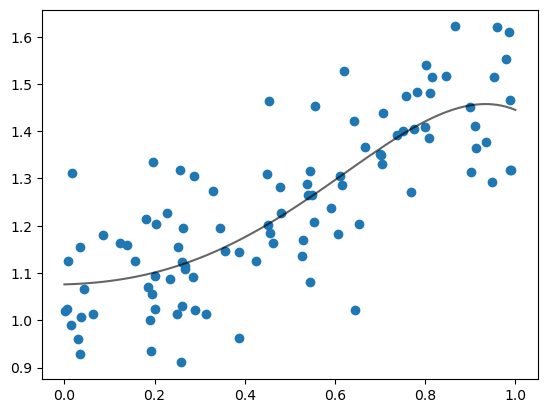

In [32]:
def loss(params, data):
    x, y = data
    return jnp.sum((y - poly(x, params))**2)

k = 6
p0 = jnp.ones(k)
p_hat = grad_descent(loss, data, p0)
print('Estimated parameter vector:')
print(p_hat)
print('\n\n')

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x_grid, poly(x_grid, p_hat), 'k-', alpha=0.6)
plt.show()